In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing library and modeules

In [3]:
import numpy as np
import tensorflow as tf

# Train and Test data

### learn more about pathlib
* https://towardsdatascience.com/10-examples-to-master-python-pathlib-1249cc77de0b

In [4]:
import pathlib
train_dir = pathlib.Path("../input/fruits/fruits-360_dataset/fruits-360/Training")
test_dir = pathlib.Path("../input/fruits/fruits-360_dataset/fruits-360/Test")

### New function/Concept 'glog()'
* The glob module is a useful part of the Python standard library. glob (short for global) is used to return all file paths that match a specific pattern.

* We can use glob to search for a specific file pattern, or perhaps more usefully, search for files where the filename matches a certain pattern by using wildcard characters.
* Learn more about glob
* https://towardsdatascience.com/the-python-glob-module-47d82f4cbd2d

In [5]:
# Total number of images in training data-set

image_count = len(list(train_dir.glob('*/*.jpg')))
image_count

67692

# Showing / Visualize Image


* here we are using matplotlib for visualizing our data
* we have open our image and converted to digits using Pillow


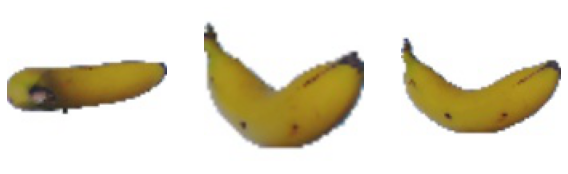

In [6]:
import matplotlib.pyplot as plt
import PIL
fruits = list(train_dir.glob('Banana/*.jpg'))

plt.figure(figsize=(10, 10))

for i in range(3):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(str(fruits[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Setting Up variables

In [7]:
batch_size = 32
img_height = 100
img_width = 100


# Collecting Data
### Used keras 'image_dataset_from_directory' API for collrcting data from directories
* Learn more about 'image_dataset_from_directory' 
* https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


2022-11-21 23:16:19.423492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 23:16:19.579878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 23:16:19.580737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 23:16:19.586229: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


# Visualizing friuts by classes

In [10]:
class_names = train_ds.class_names
num_classes = len(class_names)

2022-11-21 23:16:27.374799: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


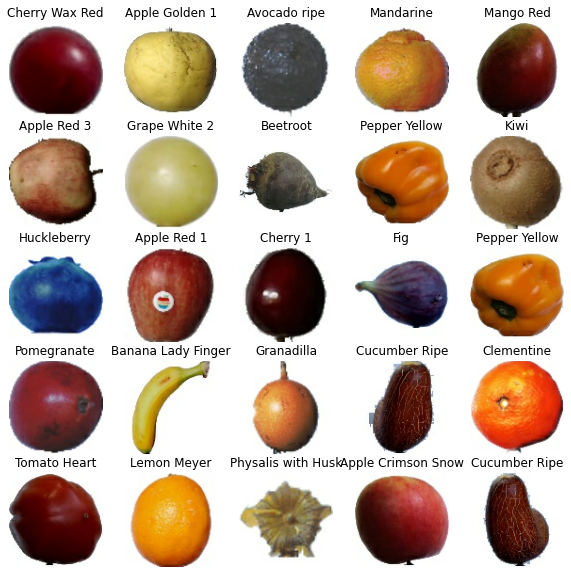

In [11]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

# Preprocessing/Setting Up Base Model

### prefetch the data for faster training while model is trained
* Learning more about prefetch and AUTOTUNE
* prefetch : https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4#:~:text=Prefetching%20solves%20the,they%20are%20requested.
* AUTOTUNE : https://stackoverflow.com/questions/56613155/tensorflow-tf-data-autotune

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data Augumentation
* Data augmentation is a set of techniques to artificially increase the amount of data by generating new data points from existing data. This includes making small changes to data or using deep learning models to generate new data points.



In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

### Using ResNEt Model for Transfer Learning
* Learn more about ResNet by going through paper
* https://paperswithcode.com/method/resnet

In [14]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [15]:
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

94781440/94765736 [==============================] - 0s 0us/step


* setting base model trainable to False so model take less time

In [16]:
base_model.trainable = False

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

# Building Model

In [18]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 100, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

# Training the model

In [21]:
model.evaluate(val_ds)

2022-11-21 23:17:58.112151: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


424/424 [==============================] - 40s 73ms/step - loss: 6.1083 - accuracy: 0.0146


[6.10833215713501, 0.014551632106304169]

* evolution accuracy is very bad but wait for traning 

In [22]:
epochs = 15

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/15


2022-11-21 23:18:54.026118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 143 of 1000
2022-11-21 23:19:04.017250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 288 of 1000
2022-11-21 23:19:14.002639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 431 of 1000
2022-11-21 23:19:24.049675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 579 of 1000
2022-11-21 23:19:34.018446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 720 of 1000
2022-11-21 23:19:44.006225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 865 of 1000


   3/1693 [..............................] - ETA: 1:41 - loss: 6.8432 - accuracy: 0.0208        

2022-11-21 23:19:53.219212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1693/1693 [==============================] - 160s 51ms/step - loss: 1.3016 - accuracy: 0.7131 - val_loss: 0.2886 - val_accuracy: 0.9617
Epoch 2/15
1693/1693 [==============================] - 54s 32ms/step - loss: 0.2196 - accuracy: 0.9602 - val_loss: 0.1175 - val_accuracy: 0.9866
Epoch 3/15
1693/1693 [==============================] - 52s 31ms/step - loss: 0.1076 - accuracy: 0.9821 - val_loss: 0.0637 - val_accuracy: 0.9947
Epoch 4/15
1693/1693 [==============================] - 52s 31ms/step - loss: 0.0632 - accuracy: 0.9905 - val_loss: 0.0405 - val_accuracy: 0.9968
Epoch 5/15
1693/1693 [==============================] - 52s 31ms/step - loss: 0.0416 - accuracy: 0.9941 - val_loss: 0.0277 - val_accuracy: 0.9983
Epoch 6/15
1693/1693 [==============================] - 52s 31ms/step - loss: 0.0307 - accuracy: 0.9956 - val_loss: 0.0214 - val_accuracy: 0.9988
Epoch 7/15
1693/1693 [==============================] - 52s 31ms/step - loss: 0.0224 - accuracy: 0.9972 - val_loss: 0.0155 - val_accur

# Visualization of Accuracy and loss

### Loss 

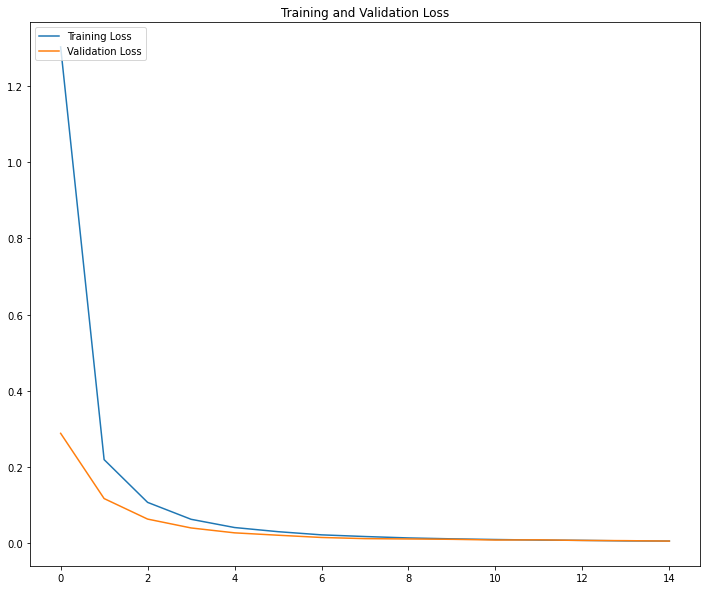

In [23]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.show()

### Accuracy

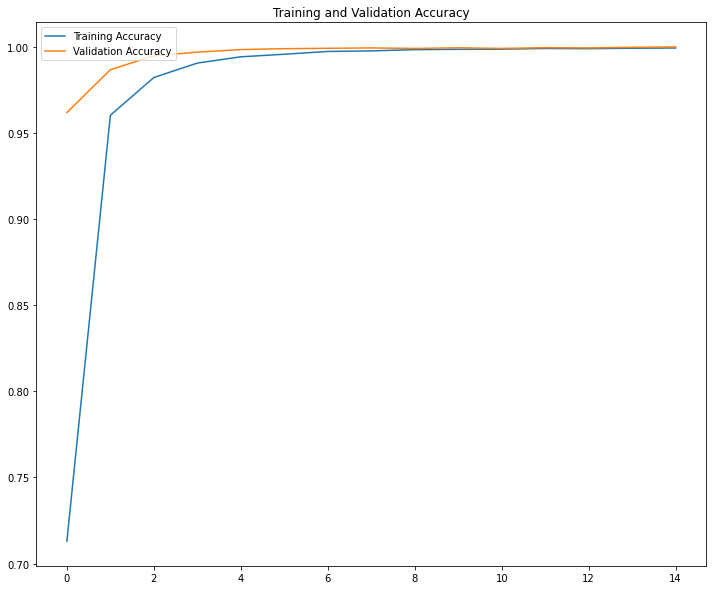

In [24]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.show()

# I hope you like this ;)

# Checking prediction on validation data-set with visualisation

In [28]:
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 0)
    return predicted_class, confidence

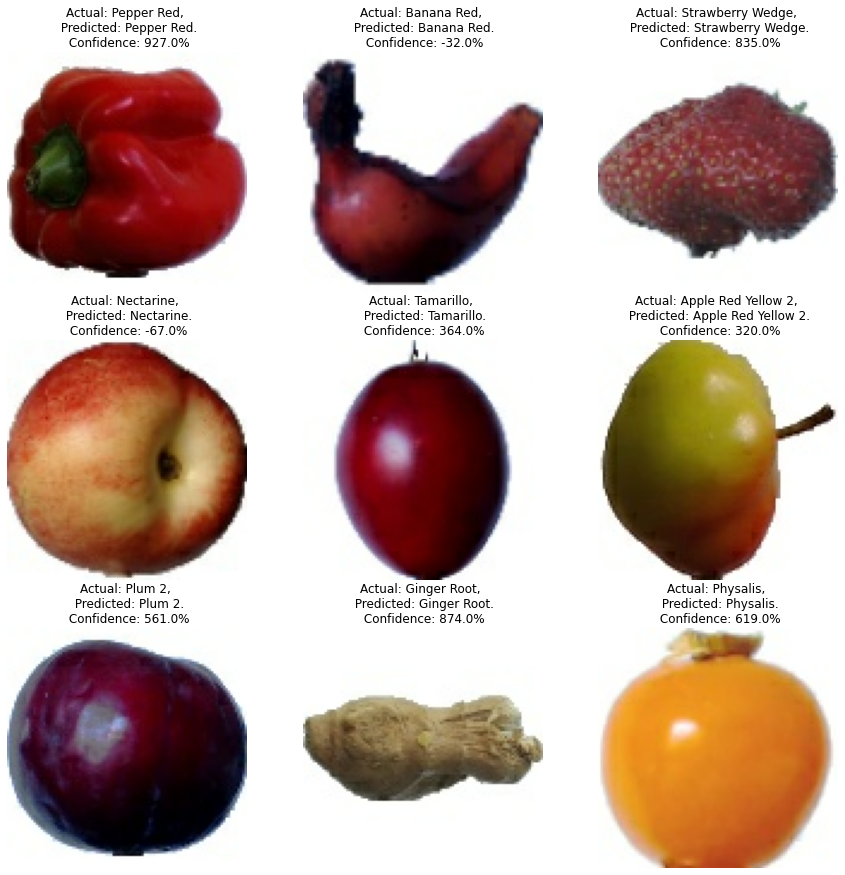

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis('off')



# Saving model

In [31]:
model_version = 1
model.save(f"./models/{model_version}")

2022-11-21 23:46:53.460996: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Zipping all the files in models

In [32]:
import shutil
shutil.make_archive("model", 'zip', './')

'/kaggle/working/model.zip'